In [1]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import sys

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
outdir = os.path.join(ciepy.root, 'output',
                      'ase_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'ase_analysis')
cpy.makedir(private_outdir)

In [38]:
def make_snv_info():
    from Bio.Seq import Seq 
    fn = ('/raid3/projects/CARDIPS/pipeline/RNAseq/'
          'exonic_snps/heterozygous_exonic_snv_information.tsv')
    info = pd.read_table(fn, index_col=0)
    info['ref_allele_stranded'] = ''
    info['alt_allele_stranded'] = ''
    info.ix[info.strand == '+', 'ref_allele_stranded'] = info.ref_allele + info.strand
    info.ix[info.strand == '+', 'alt_allele_stranded'] = info.alt_allele + info.strand
    
    info.ix[info.strand == '-', 'ref_allele_stranded'] = (info.ref_allele.apply(
            lambda x: str(Seq(x).reverse_complement())) + info.strand)
    info.ix[info.strand == '-', 'alt_allele_stranded'] = (info.alt_allele.apply(
            lambda x: str(Seq(x).reverse_complement())) + info.strand)
    return info

In [39]:
info = make_snv_info()

In [19]:
locus_fns = glob.glob(os.path.join(ciepy.root, 'output', 'input_data', 
                                   'mbased_locus', '*tsv'))
snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 
                                 'mbased_snv', '*tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 
                                   'allele_counts', '*tsv'))

In [20]:
locus_res = {}
for fn in locus_fns:
    locus_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

In [28]:
res = locus_res[locus_res.keys()[0]]
counts = pd.read_table([x for x in count_fns if locus_res.keys()[0] in x][0], index_col=0)
counts = counts[counts.sum(axis=1) > 0]

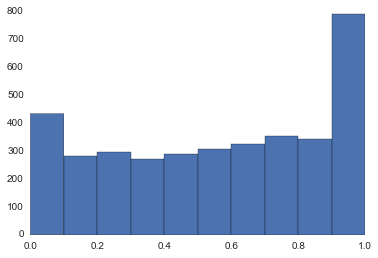

In [30]:
res.p_val_ase.hist()

In [49]:
info.ix[counts[counts.sum(axis=1) >= 10].head().index].head()

,chrom,pos,ref_allele,alt_allele,locus,name,strand,ref_allele_stranded,alt_allele_stranded
chr1:898852,chr1,898852,C,T,ENSG00000187961.9,ENSG00000187961.9_chr1:898852,+,C+,T+
chr1:982225,chr1,982225,C,T,ENSG00000188157.9,ENSG00000188157.9_chr1:982225,+,C+,T+
chr1:989234,chr1,989234,A,G,ENSG00000188157.9,ENSG00000188157.9_chr1:989234,+,A+,G+
chr1:1152631,chr1,1152631,C,A,ENSG00000078808.12,ENSG00000078808.12_chr1:1152631,-,G-,T-
chr1:1189605,chr1,1189605,G,A,ENSG00000160087.16,ENSG00000160087.16_chr1:1189605,-,C-,T-


In [48]:
counts[counts.sum(axis=1) >= 10].head()

,A+,T+,C+,G+,N+,A-,T-,C-,G-,N-
chr1:898852,0,8,6,0,0,0,0,0,0,0
chr1:982225,0,28,27,0,0,1,0,0,1,0
chr1:989234,52,0,0,35,0,0,0,0,0,0
chr1:1152631,0,0,0,0,0,0,9,0,12,0
chr1:1189605,1,0,0,0,0,0,8,1,0,0


In [50]:
tdf = info.ix[counts.index].dropna()
ref_counts = []
for i in tdf.index:
    ref_counts.append(counts.ix[i, tdf.ix[i, 'ref_allele_stranded']])
alt_counts = []
for i in tdf.index:
    alt_counts.append(counts.ix[i, tdf.ix[i, 'alt_allele_stranded']])
tdf['ref_count'] = ref_counts
tdf['alt_count'] = alt_counts
tdf = tdf[['chrom', 'pos', 'ref_allele', 'alt_allele', 'locus', 'name',
           'ref_count', 'alt_count']]
tdf['pos'] = tdf.pos.astype(int)
tdf = tdf[tdf.ref_count >= 5]
tdf = tdf[tdf.alt_count >= 5]
tdf = tdf[tdf.ref_count / (tdf.ref_count + tdf.alt_count) >= 0.1]
tdf = tdf[tdf.alt_count / (tdf.ref_count + tdf.alt_count) >= 0.1]

In [52]:
tdf.head()

,chrom,pos,ref_allele,alt_allele,locus,name,ref_count,alt_count
chr1:898852,chr1,898852,C,T,ENSG00000187961.9,ENSG00000187961.9_chr1:898852,6,8
chr1:982225,chr1,982225,C,T,ENSG00000188157.9,ENSG00000188157.9_chr1:982225,27,28
chr1:989234,chr1,989234,A,G,ENSG00000188157.9,ENSG00000188157.9_chr1:989234,52,35
chr1:1152631,chr1,1152631,C,A,ENSG00000078808.12,ENSG00000078808.12_chr1:1152631,12,9
chr1:1321998,chr1,1321998,T,C,ENSG00000221978.7,ENSG00000221978.7_chr1:1321998,5,11


In [53]:
res.head()

,major_allele_freq,p_val_ase,p_val_het,p_val_ase_bh,p_val_het_bh
ENSG00000187961.9,0.571429,0.790230,NaN,1,NaN
ENSG00000188157.9,0.563617,0.220499,0.103904,1,0.958316
ENSG00000078808.12,0.571429,0.663339,NaN,1,NaN
ENSG00000221978.7,0.687500,0.210206,NaN,1,NaN
ENSG00000179403.10,0.565217,0.677358,NaN,1,NaN


In [58]:
s = tdf.groupby('locus').sum()
s = s.ref_count + s.alt_count

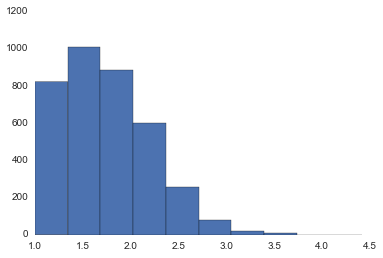

In [60]:
np.log10(s).hist()

In [80]:
for c in [20, 30, 40, 50]:
    print(c)
    print(s[s >= c].shape[0])
    print(sum(res.ix[s[s >= c].index, 'p_val_ase'] < 0.1))
    print

20
2952
428

30
2503
392

40
2142
370

50
1828
336



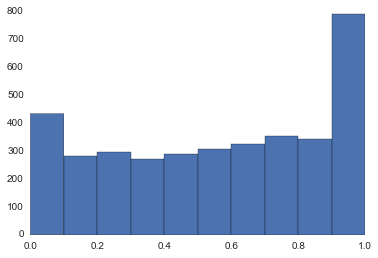

In [74]:
res.p_val_ase.hist()

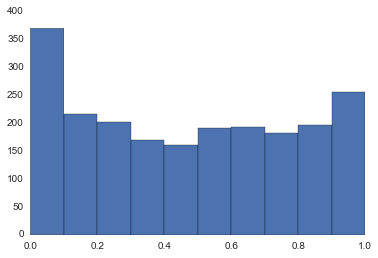

In [81]:
res.ix[s[s >= 40].index, 'p_val_ase'].hist()

In [94]:
pvals = res.ix[s[s >= 40].index, 'p_val_ase']

In [83]:
%%R -i p -o pa

pa = p.adjust(p, method="BH")

In [92]:
res.shape

(3689, 5)

In [88]:
res[res.p_val_ase_bh < 0.1].shape

(77, 5)

In [93]:
len(p)

2142

In [91]:
len(pa)

2142

In [90]:
sum(np.array(pa) < 0.1)

77

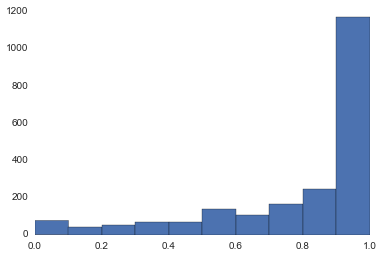

In [86]:
pd.Series(list(pa)).hist()